## Exercise 1


We will use a bike sharing dataset. The dataset contains coordinates of bike sharing stations in New York given as longitude and latitude values.

The dataset is am example dataset from the book ["Introduction to R for Business Intelligence"](https://jgendron.github.io/com.packtpub.intro.r.bi/), Packt Publishing Ltd., 2016, by Jay Gendron. The dataset is downloadable from Github [here](https://github.com/jgendron/com.packtpub.intro.r.bi/tree/master/Chapter5-ClusteringAnalysis/data).

Answer the following questions:
1. Apply K-Means clustering to the dataset. Try out different values for K and use the Elbow method to find the best (or a sensible) K.
2. Visualize the K-Means clustering result for the best K.
3. Apply Agglomerative clustering to the dataset. Draw the Dendrogram and use it to find the best (or a sensible) number of clusters.
4. Generate this number of clusters with Agglomerative clustering and visualize the clustering.
5. Apply DBSCAN clustering to the dataset. Try out different values for "eps" and "min_samples" and choose the best values. (Hint: For "eps" you probably have to try out values around 0.01.)
6. Visual the final DBSCAN clustering you decided upon in 5.
7. Calculate the Silhouette scores for the three different "best clustering" you found with the three different methods. Also use Adjusted Rand Index to compare the best ones to each other.

In [24]:
#Import Libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.cluster import KMeans

In [25]:
#Load data
locations = pd.read_csv("Datasets/Ch5_bike_station_locations.csv")
locations.head()

,latitude,longitude
0,38.956590,-76.993437
1,38.905218,-77.001496
2,38.980858,-77.054722
3,38.902925,-76.929915
4,38.949498,-77.093620


Quick EDA

In [26]:
locations.describe()

,latitude,longitude
count,244.000000,244.000000
mean,38.914289,-77.010109
std,0.035435,0.041084
min,38.827425,-77.106502
25%,38.891574,-77.031987
50%,38.916397,-77.011474
75%,38.935887,-76.985866
max,38.987980,-76.919470


In [27]:
locations.isnull().sum()

latitude     0
longitude    0
dtype: int64

In [28]:
locations.duplicated().sum()

np.int64(0)

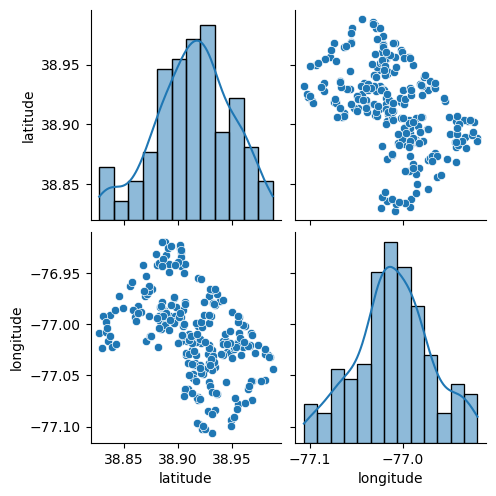

In [29]:
sns.pairplot(locations, diag_kind="hist", diag_kws={"kde":True})

We can see from the histograms that our data is not normal. That means we are probably gona make a minmax scaler.

1. Apply K-Means clustering to the dataset. Try out different values for K and use the Elbow method to find the best (or a sensible) K.

Clustering is an unsupervised model. grouping objects in a group (cluster) which aresimilar (or related) to each other and different from (or unralated) points in other groups. 
Clustering is a distance based algorithm, so first we should scale data because certain feature may dominate the distance calcualtion.

In [30]:
#Scale data
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(locations), columns=locations.columns)

The number of clusters is not pre-defined which means that we have to specify how many we wish. A good way of doing that is training models for different K, calcualte the Sum of Sqaured Errors for all points and from the plot we find the K value after which the performance gain is insignificant.

In [31]:
#Find a suitable number of k for clustering
errors = []
K = range(1, 20)
for k in K:
    kmean_model = KMeans(n_clusters=k, init='k-means++', random_state=0)
    kmean_model.fit(X_scaled) 
    errors.append(kmean_model.inertia_) # Stores the overall SSE for the model


for i in range(1, len(errors)):
    print('K={0} : {1}'.format(i+1, errors[i-1] - errors[i]))

K=2 : 12.507900789844808
K=3 : 2.8352461923578574
K=4 : 1.9234726513833422
K=5 : 1.8288879656950794
K=6 : 0.8843695879480373
K=7 : 0.2914514084486699
K=8 : 0.8886555188698484
K=9 : 0.376676864323056
K=10 : 0.27836599588343636
K=11 : 0.19145730207513867
K=12 : 0.12197708821440933
K=13 : 0.15135450691701724
K=14 : 0.1260191857265276
K=15 : 0.05639262033129899
K=16 : 0.09502710991711627
K=17 : 0.03842539098627218
K=18 : 0.07545449946116456
K=19 : 0.07744151217509165


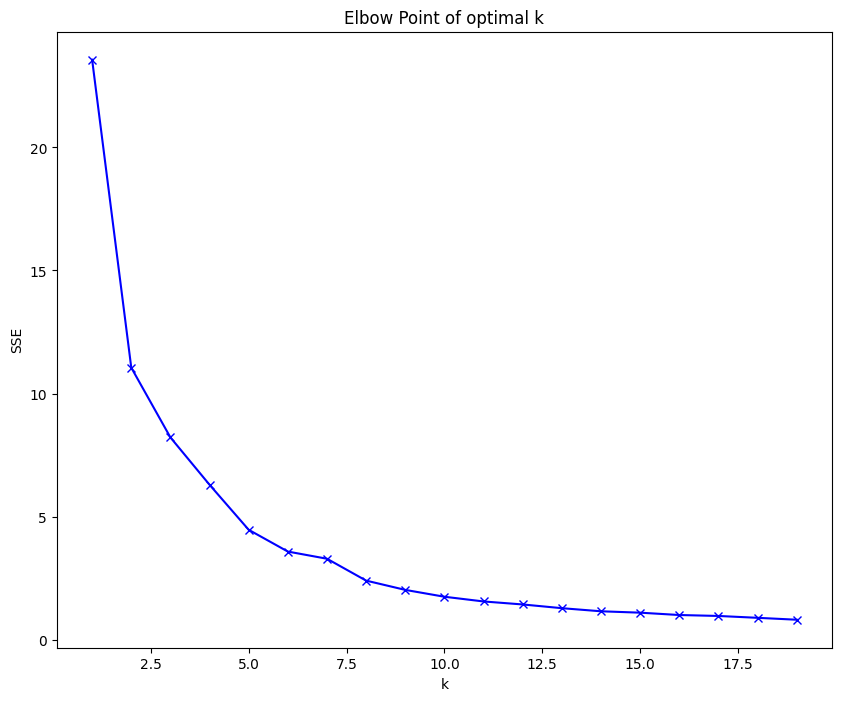

In [32]:
#Plot the sum of squared er
plt.figure(figsize=(10, 8))
plt.plot(K, errors, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Point of optimal k')
plt.show()

There is a slight increase in performance from 6 k to 7 and then it drops again. So from the plot and based on significant performance gain we assume the optimal k is 8,9 or 10 k. From the SSE table we can see that the difference from 8 to 9 is greater than form 9 to 10 k, hence we are choosing k=10.

In [33]:
#Train the model
kmean_model_scaled = KMeans(n_clusters=10)
kmean_model_scaled.fit(X_scaled)

KMeans(n_clusters=10)

2. Visualize the K-Means clustering result for the best K.

In order to visualize the clusters first we will inverse the data to their origanl form and then plot the clusters.

labels_: contains the cluster assignments for each data point.
cluster_center_: contains the coordinates of the cluster centroids in the scled data feature space.

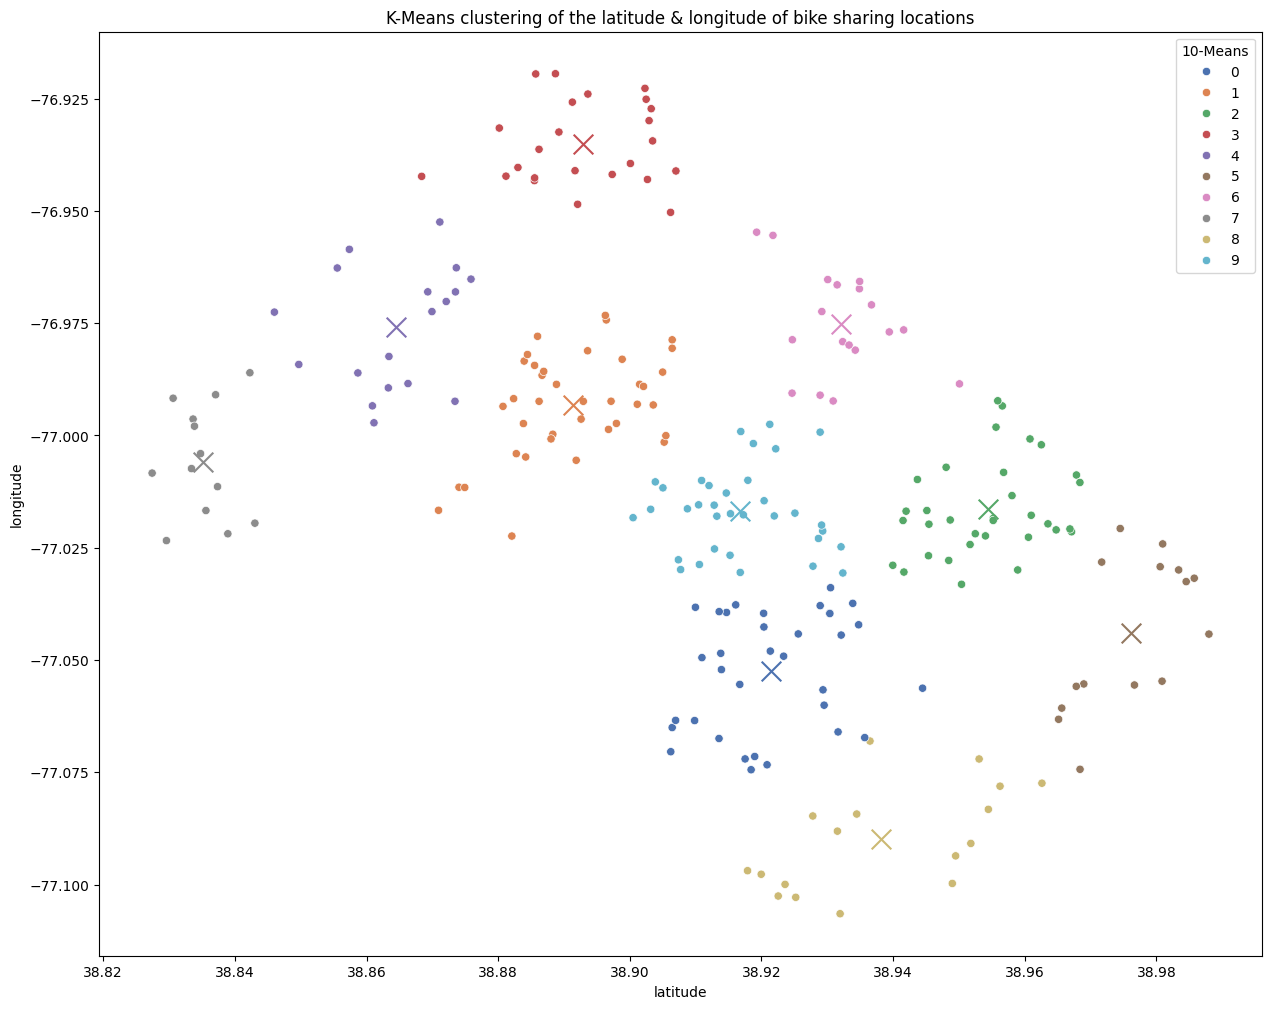

In [34]:
#Plot original data
locations["10-Means"] = kmean_model_scaled.labels_
centroids10 = scaler.inverse_transform(kmean_model_scaled.cluster_centers_)

# Create the scatter plot
plt.figure(figsize=(15, 12))
sns.scatterplot(x='latitude', y='longitude', hue='10-Means', data=locations, palette='deep')

# Plot the centroids with matching colors
for i, centroid in enumerate(centroids10):
    plt.scatter(centroid[0], centroid[1], marker='x', s=200, color=sns.color_palette('deep')[i])

plt.title('K-Means clustering of the latitude & longitude of bike sharing locations')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.legend(title='10-Means')
plt.show()

* Weaknes of K-Means
1. Applicable only to points in a continuous n-dimensional space
2. Initialization matters: Need to specify K, in advance
3. Covergence: Often terminates at a local point.
4. Sensitivity to noisy data and outliers.
5. Not suitable to discover clusters with non-convex shapes.

3. Apply Agglomerative clustering to the dataset. Draw the Dendrogram and use it to find the best (or a sensible) number of clusters.

Agglomerative clustering is a hirerchical clustering approach. They need a distance metric, but do not need a ficed number of desired clusters in advance.
* Agglomerative, initially each item is in its own cluster
* Iteratively clusters are mergred togheter
* Bottom up approach

In order to decide the optimal number of K we will plot a dendrogram. The hierarchy class has a method which takes the value returned by the linkage method of the same class. The linkage method takes the dataset and method to minimize distances as parameters. We will use ward as the method as it minimizes the variants of distnaces between the clusters.

1. Locate the largest vertical difference between nodes, avoid to merge very distant or dissimilar clusters
2. Draw a horizontal line through it. In case of more options, choose the largest veritcal difference again.
3. Count the vertical lines it intersects.

In [35]:
#Import Libraries
import scipy.cluster.hierarchy as shc

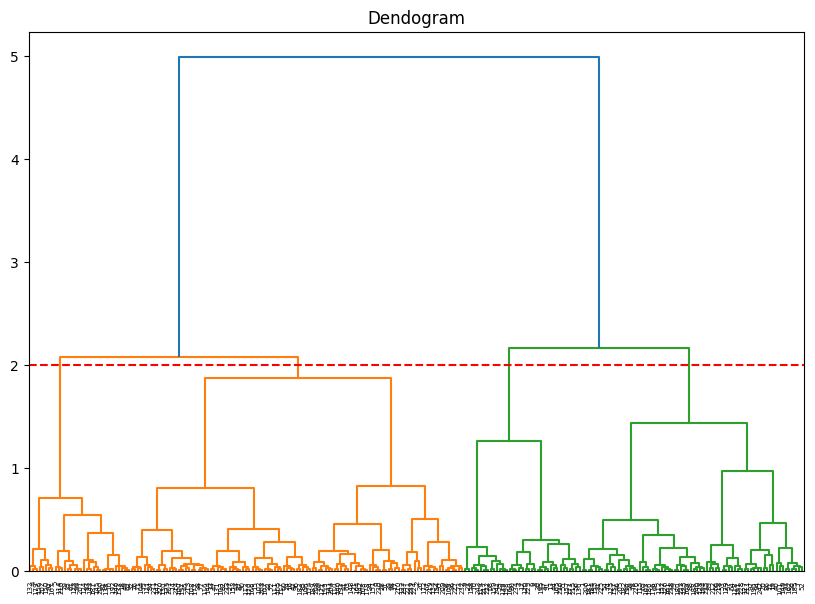

In [36]:
#Plot the dedrogram
plt.figure(figsize=(10, 7))
plt.title("Dendogram")
dend = shc.dendrogram(shc.linkage(X_scaled, method='ward'))
plt.axhline(y=2, color="r", linestyle="--")
plt.show()

The longer horizontal lines are the blue but their are pretty much the same, so we draw a line across the the left loinger orange.And twe find k-4.

4. Generate this number of clusters with Agglomerative clustering and visualize the clustering.

In [37]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

Text(0.5, 1.0, 'Agglomerative clustering of the Latitude and Longitude with 4 Clusters')

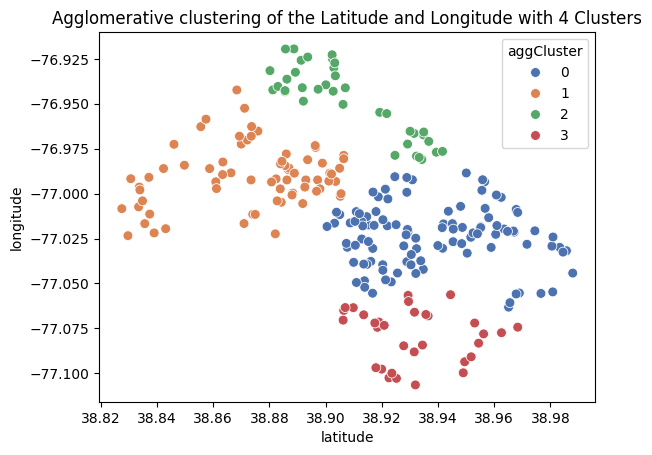

In [47]:
agg_model_scaled = AgglomerativeClustering(n_clusters=4)
agg_model_scaled.fit(X_scaled)

data_agglo = locations.copy()
data_agglo["aggCluster"] = agg_model_scaled.labels_

plt.Figure(figsize=(15,10))
sns.scatterplot(data = data_agglo, x="latitude", y="longitude", hue="aggCluster", palette="deep", s=50)
plt.title("Agglomerative clustering of the Latitude and Longitude with 4 Clusters")

5. Apply DBSCAN clustering to the dataset. Try out different values for "eps" and "min_samples" and choose the best values. (Hint: For "eps" you probably have to try out values around 0.01.)

min samples: minimum number of points in a cluster
EPS: for each point in a cluster there must be at least another one point in it less than this distance away.(DIstance between points)

A cluster satisfies two properties
1. All points within a cluster are mutually density-connected
2. If a point p is density-connected to any point of a cluster, r belongs to the same cluster as well

In [39]:
#Import Nearest Neighbours
from sklearn.neighbors import NearestNeighbors

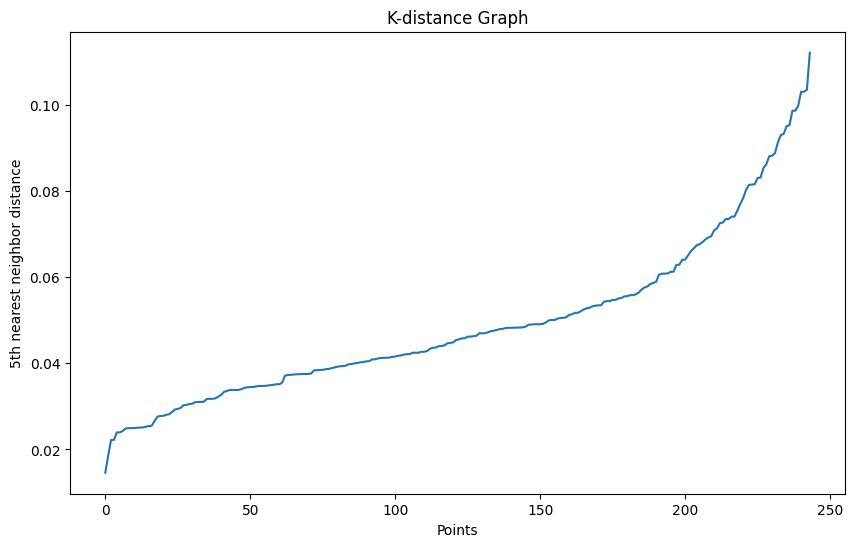

In [40]:
#Find the best eps from the elbow graph
for eps in np.arange(0.06, 0.0012, -0.001):
    n = NearestNeighbors(n_neighbors=5) #Arbitrary choosen
    n.fit(X_scaled)
    distances, _ = n.kneighbors(X_scaled)
    distances = np.sort(distances[:, 5-1])

plt.figure(figsize=(10,6))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("5th nearest neighbor distance")
plt.title("K-distance Graph")
plt.show()

The k-distance graph method helps us to chose the eps value. It calculates the distance for each data point to the k-th nearest neaighbour. In our case since we have 5 neighbors in calcualtes the distance to the 5th nearest neighbor. Then we sort the distances in ascending order and plot them. The value of eps will be optimal around the elbow point, where the cahnge in distances begins to increase more. This point indicates a transition from points with denser regions to point in sparse region or noise. Beyond this point, increasing eps provides small improvemnts in terms of capturing denser clusters with increased computational cost.

To sum it up, from our plot we are choosing 0.04 or 0.05.

In [41]:
#Import Library
from sklearn.cluster import DBSCAN

In [42]:
#Another way to define eps
#Multiple DBSCAN clusters
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import silhouette_score

eps = np.arange(0.06, 0.0012, -0.001)
min_samples = range(3, 50)
best_eps, best_min_samples, best_score = None, None, -1
dbscan_data = X_scaled.copy()
score = 0

for e in eps:
    for s in min_samples:
        dbscan = DBSCAN(eps=e, min_samples= s)
        clusters = dbscan.fit_predict(X_scaled)

        if len(set(clusters)) <= 1:
            continue

        dbscan_data["DBSCAN"] = dbscan.labels_
        score = silhouette_score(X_scaled, labels=dbscan_data["DBSCAN"])
        if score > best_score:
            best_eps, best_min_samples, best_score = e, s, score

print(f"Best EPS: {best_eps}, Best min_samples: {best_min_samples}, Best Silhouette Score: {best_score}")

Best EPS: 0.04799999999999999, Best min_samples: 3, Best Silhouette Score: 0.3367213477659877


In this way we loop through values defined for eos and min samples and evaluate the model with the silhoutte score. So the highest score indicates the desired eps and number of samples. 
From this approach we also can see that the eps we found before is close to this one. So to round this approach we will choose 0.0479.

6. Visual the final DBSCAN clustering you decided upon in 5

In [43]:
#Train the model
dbscan_best = DBSCAN(eps=0.0479, min_samples=3)
clusters = dbscan_best.fit_predict(X_scaled)
dbscan_data["DBSCAN"] = dbscan_best.labels_

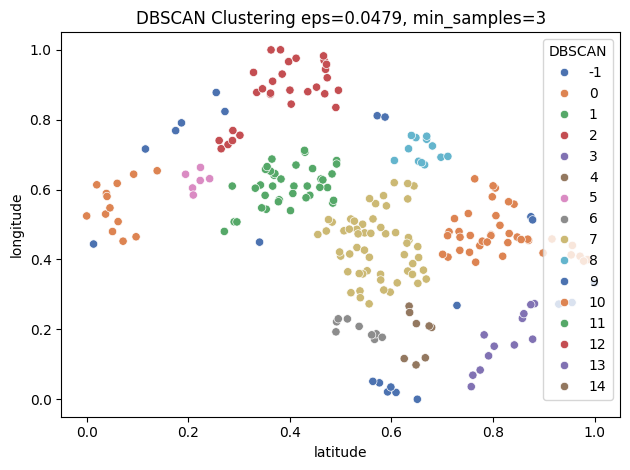

In [48]:
#Plot the Clustering
sns.scatterplot(data=dbscan_data, x="latitude", y="longitude", hue="DBSCAN", palette="deep")
plt.title("DBSCAN Clustering eps=0.0479, min_samples=3")
plt.tight_layout()
plt.show()

7. Calculate the Silhouette scores for the three different "best clustering" you found with the three different methods. Also use Adjusted Rand Index to compare the best ones to each other.

In [45]:
SilScore_df = pd.DataFrame(
    {
        "Clustering Method":["K-means", "Agglomerative", "DBSCAN"],
        "silhouette_score":[
            silhouette_score(X_scaled, labels=locations["10-Means"]),
            silhouette_score(X_scaled, labels=data_agglo["aggCluster"]),
            silhouette_score(X_scaled, labels=dbscan_data["DBSCAN"])
        ]
    }
)
SilScore_df

,Clustering Method,silhouette_score
0,K-means,0.446225
1,Agglomerative,0.366738
2,DBSCAN,0.324910


K-means clustering perfomred best, indicating better-defined clusters compared to Agglo and DBSCAN.

Adjusted Rand Score tell us about if the clusterings are the same or not. Ranges from 0 to 1, 0 indicating a random assignemts of data points to clusters and 1 indicating that the partitionings of clusters is a perfect match.

In [46]:
ARI_df = pd.DataFrame({"Clustering method": ["KMeans", "Agglomerative", "DBSCAN",], 
                       "Comparative clustering method": ["Agglomerative","DBSCAN", "KMeans" ],
                       "Adjusted Rand Score": [adjusted_rand_score(locations["10-Means"], data_agglo["aggCluster"]),
                                               adjusted_rand_score(data_agglo["aggCluster"], dbscan_data["DBSCAN"]),
                                               adjusted_rand_score(locations["10-Means"], dbscan_data["DBSCAN"]),
                                               ]})
ARI_df

,Clustering method,Comparative clustering method,Adjusted Rand Score
0,KMeans,Agglomerative,0.366557
1,Agglomerative,DBSCAN,0.461287
2,DBSCAN,KMeans,0.638029


DBSCAN and Kmeans are pretty similar between each other. As well as Agglomerative and Dbscan are somewhat of similar. The less resembles is in KMeasn and Agglomerative.
